### Growth factor-mediated coupling between lineage size and cell fate choice underlies robustness of mammalian development

#### N. Saiz, L. Mora-Bitria, S. Rahman, H. George, J.P. Herder, J. García-Ojalvo and A.-K. Hadjantonakis

**Figure 2e**

This code reproduces the average lineage dynamics of our minimal model of EPI-PrE cell fate choice in the early embryo, for embryo sizes double and half the wild-type case. Running this code requires the C compiler `cc` and the utility `make`. Both are available by default in Linux, or by installing the `Xcode` development environment in Mac OS X.

First, we load all necessary packages:

In [1]:
import numpy as np
from IPython.display import clear_output
import subprocess
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 20

Now we compile the C code:

In [2]:
try:
    out = subprocess.check_output('make --file=Makefile_v1 clean', shell=True)
    outlist = out.decode().split('\n')
    for outline in outlist:
        print(outline)
except:
    pass

p = subprocess.Popen(["make","--file=Makefile_v1"],stdout=subprocess.PIPE,stderr=subprocess.PIPE)
while True:
    ln = p.stdout.readline().decode().rstrip()
    if ln == '':
            break
    print(ln)
while True:
    ln = p.stderr.readline().decode().rstrip()
    if ln == '':
            break
    print(ln)

rm *.o

cc -O3 -c dran.c -o dran.o
cc -O3 -c embryo_v1.c
cc embryo_v1.o dran.o -o embryo_v1 -lm


We now define a function `run` that generates the parameter value file and runs the C code. Some of the parameters are introduced as arguments to the function, the rest are hard-coded within it.

In [3]:
def run(nruns=10, alpha=10, Kf=0.9, nth=0.8, gth=0.2, n0=2, n0sd=0,
        N2start=20, N2startsd=2, N2ablate=100, fate2ablate=3, p2ablate=0.3,
        mt=0.01, rntd=0.01, nth2=0.95, gth2=0.05, Nmax=50, rngseed=1000):
    fname = 'output/dset_v1_%i'%rngseed
    pfile = open(fname+'.par', 'w')
    pfile.write('%s    nruns\n'%nruns)
    pfile.write('1e-6    initial_mass\n')
    pfile.write('5.0    initial_radius\n')
    pfile.write('1e-6    effective_friction\n')
    pfile.write('1e-4    adhesion_strength\n')
    pfile.write('1.5    adhesion_strength_reduction_for_different_cell_types\n')
    pfile.write('2.0    adhesion_range\n')
    pfile.write('%s    alpha\n'%alpha)
    pfile.write('%s    Kf\n'%Kf)
    pfile.write('2    nh\n')
    pfile.write('2    mh\n')
    pfile.write('1.2    fd_FGF_range_factor\n')
    pfile.write('%s    nth_minimum_fraction_of_Nanog_max_for_EPI_allocation\n'%nth)
    pfile.write('%s    gth_maximum_fraction_of_Nanog_max_for_PrE_allocation\n'%gth)
    pfile.write('%s    nth2_maximum_Nanog_max_for_circuit_function\n'%nth2)
    pfile.write('%s    gth2_minimum_Nanog_max_for_circuit_function\n'%gth2)
    pfile.write('%s    maximum_cell_number\n'%Nmax)
    pfile.write('10         division_time\n')
    pfile.write('0.5         dispersion_in_division_time\n')
    pfile.write('300.0         final_time\n')
    pfile.write('%s          measuring_time\n'%mt)
    pfile.write('0.001        integration_time_step\n')
    pfile.write('%i          random_number_generator_seed\n'%rngseed)   #rng seed
    pfile.write('%s          initial_DC_Nanog\n'%n0)
    pfile.write('%s          initial_noise_Nanog\n'%n0sd)
    pfile.write('%s          division_noise\n'%rntd)  #0.01
    pfile.write('%s          mean_cell_number_to_start_biochemistry\n'%N2start)
    pfile.write('%s          std_cell_number_to_start_biochemistry\n'%N2startsd)
    pfile.write('%s          cell_number_to_start_ablation\n'%N2ablate)
    pfile.write('%s          cell_type_to_ablate\n'%fate2ablate)
    pfile.write('%s          cell_fraction_to_ablate\n'%p2ablate)
    pfile.close()

    p = subprocess.Popen(['time','embryo_v1',fname],
                         stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    while True:
        ln = p.stdout.readline().decode().rstrip()
        if ln == '':
                break
        print(ln)
    while True:
        ln = p.stderr.readline().decode().rstrip()
        if ln == '':
                break
        print(ln)

Next we define two plotting functions:

In [4]:
def plot_fractions_vs_time(N2ablate=100,fate2ablate=3,nruns=1,p2ablate=0.3,
                           title=False,tmin=40*90/56,tmax=60*90/56,
                           tshift=0,nmin=-1,nmax=50,sfactor=1):
    tscale = 90/56
    fname = 'output/dset_v1_%i'%rngseed
    tvec = []
    fdpvec = []
    fepivec = []
    fprevec = []
    fdp2vec = []
    fepi2vec = []
    fpre2vec = []
    Nvec = []
    if nruns>1:
        sddpvec = []
        sdepivec = []
        sdprevec = []
        sdNvec = []
    data = open(fname+'.dat', 'r')
    for it,line in enumerate(data):
        snap_raw = line.rstrip(' \n').split(' ')
        snap = np.array(list(map(float, snap_raw)))
        tvec.append(snap[0]+tshift)
        fdpvec.append(snap[1]*100)
        fepivec.append(snap[2]*100)
        fprevec.append(snap[3]*100)
        fdp2vec.append(snap[4]*100)
        fepi2vec.append(snap[5]*100)
        fpre2vec.append(snap[6]*100)
        Nvec.append(snap[7])
        if nruns>1:
            if snap[4]-snap[1]**2>0:
                sddpvec.append(np.sqrt(snap[4]-snap[1]**2)*100)
            else:
                sddpvec.append(0)
            if snap[5]-snap[2]**2>0:
                sdepivec.append(np.sqrt(snap[5]-snap[2]**2)*100)
            else:
                sdepivec.append(0)
            if snap[6]-snap[3]**2>0:
                sdprevec.append(np.sqrt(snap[6]-snap[3]**2)*100)
            else:
                sdprevec.append(0)
            if snap[8]-snap[7]**2>0:
                sdNvec.append(np.sqrt(snap[8]-snap[7]**2))
            else:
                sdNvec.append(0)
    if fate2ablate == 0:
        abtype = 'DP'
    if fate2ablate == 1:
        abtype = 'EPI'
    if fate2ablate == 2:
        abtype = 'PrE'
    if fate2ablate == 3:
        abtype = 'Random'
    plt.figure()
    ax1 = plt.gca()
    if title:
        ax1.title('%s, %s-cell stage, %s runs, %s fraction'%(abtype,N2ablate,nruns,p2ablate),fontsize=15)
    ax2 = ax1.twinx()
    if nruns>1:
        ax1.errorbar(np.asarray(tvec)*tscale,fdpvec,yerr=sddpvec,capsize=4,fmt='om-',label='DP')
        ax1.errorbar(np.asarray(tvec)*tscale,fepivec,yerr=sdepivec,capsize=4,fmt='or-',label='EPI')
        ax1.errorbar(np.asarray(tvec)*tscale,fprevec,yerr=sdprevec,capsize=4,fmt='ob-',label='PrE')
        ax2.errorbar(np.asarray(tvec)*tscale,Nvec,yerr=sdNvec,fmt='o-',color='grey',label='all')
    else:
        ax1.plot(np.asarray(tvec)*tscale,fdpvec,'m-',label='DP')
        ax1.plot(np.asarray(tvec)*tscale,fepivec,'r-',label='EPI')
        ax1.plot(np.asarray(tvec)*tscale,fprevec,'b-',label='PrE')
        ax2.plot(np.asarray(tvec)*tscale,Nvec,'grey',label='all')
    if N2ablate<100:
        ax2.axhline(N2ablate,color='k',linestyle=':')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc=2, fontsize=15)
    ax1.axhline(50,color='k',linestyle='--')
    ax1.set_xlabel('time (hpf)')
    ax1.set_ylabel('% of ICM')
    ax1.set_xlim([tmin,tmax])
    ax1.set_ylim([-2,102])
    ax2.set_ylabel('cell number', rotation=270, labelpad=20, color='grey')
    ax2.tick_params(axis='y', colors='grey')
    ax2.set_ylim([nmin,nmax])
    plt.tight_layout()
    plt.savefig('fig2e_%sx.pdf'%sfactor)
    plt.show()

Using the functions defined above, now we run the simulations for an ensemble of realizations, and plot the average number of cells in each lineage, as a function of time.

      220.87 real       206.87 user         1.31 sys


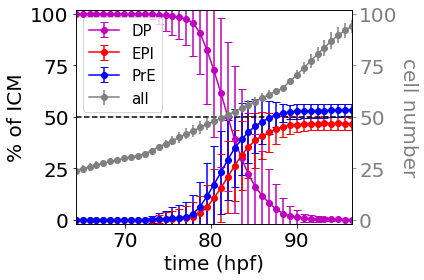

In [5]:
nruns = 100         # Number of simulation runs
rngseed = 1202      # Seed of random number generator
N2start = 40        # Number of cells at which biochemical regulation starts
N2startsd = 4       # Standard deviation of N2start
Nmax = 100          # Cell number at which simulation should stop
mt = 0.5            # Time between measures

run(nruns=nruns, N2start=N2start, N2startsd=N2startsd,
    Nmax=Nmax, mt=mt, rngseed=rngseed)

plot_fractions_vs_time(nruns=nruns, tshift=-10, nmin=-2, nmax=102, sfactor=2)

       45.10 real        43.61 user         0.27 sys


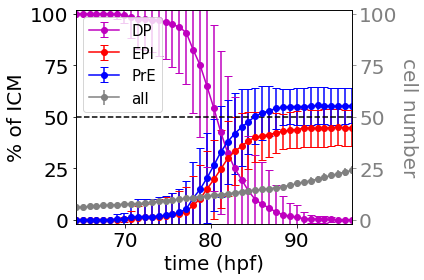

In [6]:
nruns = 100         # Number of simulation runs
rngseed = 1200      # Seed of random number generator
N2start = 10        # Number of cells at which biochemical regulation starts
N2startsd = 1       # Standard deviation of N2start
mt = 0.5            # Time between measures

run(nruns=nruns, N2start=N2start, N2startsd=N2startsd, mt=mt, rngseed=rngseed)

plot_fractions_vs_time(nruns=nruns, tshift=10, nmin=-2, nmax=102, sfactor=0.5)